In [94]:
import pandas as pd
from analysis import data
from result import Ok, Err
import itertools
from tqdm.auto import tqdm

In [95]:
invalid_eyetracking_data = data.load_yaml("../data/raw/invalid_eyetracking_data.yaml")

In [96]:
#invalid_eyetracking_data = data.load_yaml("../data/raw/invalid_eyetracking_data.yaml")
def load_fnir_data():
    def load_fnir_df(pid, tid, experiment_dir):
        fnir_path = experiment_dir / "processed-new" / "fnir.json"
        try:
            df = pd.read_json(fnir_path)
            df['pid'] = pid
            df['tid'] = tid
            return Ok(df.set_index(['pid', 'tid']))
        except Exception as e:
            return Err(e)

    #experiment_dirs = data.iter_experiment_dir("/Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData")
    experiment_dirs = data.iter_experiment_dir("/Users/zhangziyi/Library/CloudStorage/OneDrive-Personal/WSU-SEL-shared-all/Experiments/Experiment-Data/ReadingStrategyExperiemntData")
    fnir_dfs = itertools.starmap(load_fnir_df, experiment_dirs)
    fnir_dfs = list(tqdm(fnir_dfs))
    for fnir_df in fnir_dfs:
        if isinstance(fnir_df, Err):
            print(fnir_df)
    fnir_dfs = filter(lambda x: isinstance(x, Ok), fnir_dfs)
    
    fnir_dfs = map(lambda x: x.unwrap(), fnir_dfs)

    fnirs = pd.concat(fnir_dfs)
    for pid, tids in invalid_eyetracking_data.items():
        for tid in tids:
            fnirs = fnirs.drop((pid, tid), errors="ignore")
            
    return fnirs

def load_manual_annotation_data():
    manual_annotations = pd.read_parquet('../data/processed/manual_pattern_annotations.parq')

    for pid, tids in invalid_eyetracking_data.items():
        for tid in tids:
            manual_annotations = manual_annotations.drop((pid, tid), errors="ignore")

    return manual_annotations

def get_experiment_durations(filepath="../data/raw/eyetracking/core.parq", invalid_eyetracking_data=None):
    if invalid_eyetracking_data is None:
        invalid_eyetracking_data = {}

    core_data = pd.read_parquet(filepath).set_index(['pid', 'tid'])
    experiment_durations = core_data.groupby(["pid", "tid"])["core_time"].agg(np.ptp) / 1000
    for pid, tids in invalid_eyetracking_data.items():
        for tid in tids:
            experiment_durations = experiment_durations.drop((pid, tid),errors="ignore")# )
    return experiment_durations

# experiment_durations = get_experiment_durations(invalid_eyetracking_data=invalid_eyetracking_data)
# experiment_durations.reset_index(name="duration(s)").set_index(
#     ["pid", "tid"]
# ).to_parquet("../data/processed/experiment_durations.parq")

def load_experiment_durations():
    return pd.read_parquet("../data/processed/experiment_durations.parq")

In [100]:
fnirs, patterns = load_fnir_data(), load_manual_annotation_data()

381it [00:04, 84.03it/s] 


Err(FileNotFoundError('File /Users/zhangziyi/Library/CloudStorage/OneDrive-Personal/WSU-SEL-shared-all/Experiments/Experiment-Data/ReadingStrategyExperiemntData/p100/t1/processed-new/fnir.json does not exist'))
Err(FileNotFoundError('File /Users/zhangziyi/Library/CloudStorage/OneDrive-Personal/WSU-SEL-shared-all/Experiments/Experiment-Data/ReadingStrategyExperiemntData/p4/t2/processed-new/fnir.json does not exist'))
Err(FileNotFoundError('File /Users/zhangziyi/Library/CloudStorage/OneDrive-Personal/WSU-SEL-shared-all/Experiments/Experiment-Data/ReadingStrategyExperiemntData/p4/t3/processed-new/fnir.json does not exist'))
Err(FileNotFoundError('File /Users/zhangziyi/Library/CloudStorage/OneDrive-Personal/WSU-SEL-shared-all/Experiments/Experiment-Data/ReadingStrategyExperiemntData/p4/t4/processed-new/fnir.json does not exist'))
Err(FileNotFoundError('File /Users/zhangziyi/Library/CloudStorage/OneDrive-Personal/WSU-SEL-shared-all/Experiments/Experiment-Data/ReadingStrategyExperiemntData/p

In [101]:
print(patterns.columns)

Index(['snippet', 'correctness', 'investment', 'selection_strategy',
       'direction', 'code_interaction', 'intent', 'start_time', 'end_time',
       'duration'],
      dtype='object')


In [64]:
fnirs.to_clipboard()

In [65]:
fnirs.to_csv('../data/interim/fnirs.csv')

In [102]:
patterns.groupby(['selection_strategy']).size() / len(patterns)

selection_strategy
Dynamic        0.730375
Linear         0.252560
No strategy    0.017065
dtype: float64

In [103]:
patterns.groupby(['snippet', 'direction']).size() / len(patterns)

snippet         direction                             
Calculation     Back and forth                            0.029010
                Back and forth the order of denifition    0.010239
                Backward                                  0.003413
                Forward                                   0.034130
                In the order of definition                0.010239
                No direction                              0.001706
                Reverse the order of definition           0.001706
Graph Utils     Back and forth                            0.056314
                Back and forth the order of denifition    0.000000
                Backward                                  0.011945
                Forward                                   0.078498
                In the order of definition                0.000000
                No direction                              0.005119
                Reverse the order of definition           0.000000
Inserti

In [104]:
patterns.groupby(['investment']).size() / len(patterns)

investment
Indepth    0.196246
Medium     0.598976
Quick      0.204778
dtype: float64

In [105]:
patterns['pattern'] = [(a, b, c, d) for a, b, c, d in zip(patterns['investment'], patterns['direction'], patterns['selection_strategy'], patterns['code_interaction'], )]

In [106]:
patterns.groupby('pattern').size().sort_values(ascending=False) / len(patterns)

pattern
(Medium, Forward, Dynamic, Intra procedure)                                   0.153584
(Medium, Back and forth, Dynamic, Intra procedure)                            0.098976
(Medium, Forward, Linear, Intra procedure)                                    0.083618
(Medium, Forward, Dynamic, Inter procedure)                                   0.046075
(Indepth, Forward, Dynamic, Intra procedure)                                  0.044369
(Indepth, Forward, Linear, Intra procedure)                                   0.042662
(Indepth, Back and forth, Dynamic, Intra procedure)                           0.039249
(Quick, Forward, Dynamic, Intra procedure)                                    0.039249
(Quick, Back and forth, Dynamic, Intra procedure)                             0.037543
(Medium, Back and forth the order of denifition, Dynamic, Inter procedure)    0.034130
(Medium, Backward, Dynamic, Intra procedure)                                  0.032423
(Medium, Back and forth, Dynamic, I

In [107]:
patterns

snippet  correctness investment selection_strategy  \
pid tid                                                          
p52 t1   Number HRD         True     Medium        No strategy   
    t1   Number HRD         True     Medium            Dynamic   
    t1   Number HRD         True     Medium             Linear   
    t1   Number HRD         True     Medium            Dynamic   
    t1   Number HRD         True     Medium             Linear   
...             ...          ...        ...                ...   
p48 t1   Number HRD         True    Indepth            Dynamic   
p74 t3   Number HRD         True     Medium             Linear   
    t3   Number HRD         True      Quick            Dynamic   
    t3   Number HRD         True     Medium             Linear   
    t3   Number HRD         True     Medium            Dynamic   

              direction code_interaction  \
pid tid                                    
p52 t1         Backward  Intra procedure   
    t1     No direction  Intra procedure   
    t1          Forward  Intra procedure   
    t1          Forward  Intra procedure   
    t1   Back and forth  Intra procedure   
...                 ...              ...   
p48 t1   Back and forth  Intra procedure   
p74 t3          Forward  Intra procedure   
    t3   Back and forth  Intra procedure   
    t3          Forward  Intra procedure   
    t3   Back and forth  Intra procedure   

                                                intent  start_time  end_time  \
pid tid                                                                        
p52 t1   Get the understanding of a part of code block           0         7   
    t1   Get the understanding of a part of code block           7        35   
    t1   Get the understanding of a part of code block          35        55   
    t1   Get the understanding of a part of code block          55        95   
    t1   Get the understanding of a part of code block         102       116   
...                                                ...         ...       ...   
p48 t1                   Validate the hypothesis of PA         258       291   
p74 t3   Get the understanding of a part of code block           0        23   
    t3                Get a quick overview of the code          48       147   
    t3   Get the understanding of a part of code block         147       248   
    t3   Get the understanding of a part of code block         248       500   

         duration                                            pattern  
pid tid                                                               
p52 t1          7   (Medium, Backward, No strategy, Intra procedure)  
    t1         28   (Medium, No direction, Dynamic, Intra procedure)  
    t1         20         (Medium, Forward, Linear, Intra procedure)  
    t1         40        (Medium, Forward, Dynamic, Intra procedure)  
    t1         14  (Medium, Back and forth, Linear, Intra procedure)  
...           ...                                                ...  
p48 t1         33  (Indepth, Back and forth, Dynamic, Intra proce...  
p74 t3         23         (Medium, Forward, Linear, Intra procedure)  
    t3         99  (Quick, Back and forth, Dynamic, Intra procedure)  
    t3        101         (Medium, Forward, Linear, Intra procedure)  
    t3        252  (Medium, Back and forth, Dynamic, Intra proced...  

[586 rows x 11 columns]

In [118]:
core_data = pd.read_parquet("../data/raw/eyetracking/plugin.parq")
experiment_duration = (
    core_data.groupby(["pid", "tid"])["plugin_time"]
    .agg(lambda x: x.max() - x.min())
    .reset_index(name="experiment_duration")
)
pattern_counts = (
    patterns.reset_index()
    .groupby(["pid", "tid", "pattern", 'intent'])
    .size()
    .reset_index(name="pattern_count", level=2)
)  # .merge(experiment_duration.set_index(['pid', 'tid']))
pattern_counts = experiment_duration.set_index(["pid", "tid"]).join(
    pattern_counts, how="right"
).join(patterns.groupby(level=[0, 1])['correctness'].agg(lambda x: x[0]))
pattern_counts["normalized_pattern_count"] = (
    pattern_counts["pattern_count"] / pattern_counts["experiment_duration"]
)


In [119]:
pattern_counts

experiment_duration  \
pid  tid intent                                                                    
p101 t1  Formulate a hypothesis of the problematic area ...              90635.0   
         Validate the hypothesis of PA                                   90635.0   
         Get the deeper understanding of the code                        90635.0   
         Get the understanding of a part of code block                   90635.0   
     t2  Formulate a hypothesis of the problematic area ...              55997.0   
...                                                                          ...   
p99  t3  Formulate a hypothesis of the problematic area ...             115152.0   
         Formulate a hypothesis of the problematic area ...             115152.0   
         Get the understanding of a part of code block                  115152.0   
         Get the deeper understanding of the code                       115152.0   
         Get a quick overview of the code                               115152.0   

                                                                                                       pattern  \
pid  tid intent                                                                                                  
p101 t1  Formulate a hypothesis of the problematic area ...  (Medium, Back and forth the order of denifitio...   
         Validate the hypothesis of PA                             (Medium, Forward, Dynamic, Inter procedure)   
         Get the deeper understanding of the code            (Medium, In the order of definition, Linear, I...   
         Get the understanding of a part of code block             (Quick, Backward, Dynamic, Intra procedure)   
     t2  Formulate a hypothesis of the problematic area ...  (Medium, Back and forth, Dynamic, Intra proced...   
...                                                                                                        ...   
p99  t3  Formulate a hypothesis of the problematic area ...  (Indepth, In the order of definition, Dynamic,...   
         Formulate a hypothesis of the problematic area ...  (Medium, Back and forth the order of denifitio...   
         Get the understanding of a part of code block              (Medium, Forward, Linear, Intra procedure)   
         Get the deeper understanding of the code            (Medium, In the order of definition, Dynamic, ...   
         Get a quick overview of the code                    (Quick, Reverse the order of definition, Dynam...   

                                                             pattern_count  \
pid  tid intent                                                              
p101 t1  Formulate a hypothesis of the problematic area ...              1   
         Validate the hypothesis of PA                                   1   
         Get the deeper understanding of the code                        1   
         Get the understanding of a part of code block                   1   
     t2  Formulate a hypothesis of the problematic area ...              1   
...                                                                    ...   
p99  t3  Formulate a hypothesis of the problematic area ...              1   
         Formulate a hypothesis of the problematic area ...              1   
         Get the understanding of a part of code block                   1   
         Get the deeper understanding of the code                        1   
         Get a quick overview of the code                                1   

                                                             correctness  \
pid  tid intent                                                            
p101 t1  Formulate a hypothesis of the problematic area ...         True   
         Validate the hypothesis of PA                              True   
         Get the deeper understanding of the code                   True   
         Get the understanding of a part of code block              True   
     t2  Formu

In [120]:
pattern_counts.groupby(
    [
        "pattern",
        "correctness",
        
    ]
)[
    "normalized_pattern_count"
].sum().reset_index(name="sum_normalized_frequency").pivot_table(values="sum_normalized_frequency", index="pattern", columns="correctness").to_clipboard()

pattern_counts


experiment_duration  \
pid  tid intent                                                                    
p101 t1  Formulate a hypothesis of the problematic area ...              90635.0   
         Validate the hypothesis of PA                                   90635.0   
         Get the deeper understanding of the code                        90635.0   
         Get the understanding of a part of code block                   90635.0   
     t2  Formulate a hypothesis of the problematic area ...              55997.0   
...                                                                          ...   
p99  t3  Formulate a hypothesis of the problematic area ...             115152.0   
         Formulate a hypothesis of the problematic area ...             115152.0   
         Get the understanding of a part of code block                  115152.0   
         Get the deeper understanding of the code                       115152.0   
         Get a quick overview of the code                               115152.0   

                                                                                                       pattern  \
pid  tid intent                                                                                                  
p101 t1  Formulate a hypothesis of the problematic area ...  (Medium, Back and forth the order of denifitio...   
         Validate the hypothesis of PA                             (Medium, Forward, Dynamic, Inter procedure)   
         Get the deeper understanding of the code            (Medium, In the order of definition, Linear, I...   
         Get the understanding of a part of code block             (Quick, Backward, Dynamic, Intra procedure)   
     t2  Formulate a hypothesis of the problematic area ...  (Medium, Back and forth, Dynamic, Intra proced...   
...                                                                                                        ...   
p99  t3  Formulate a hypothesis of the problematic area ...  (Indepth, In the order of definition, Dynamic,...   
         Formulate a hypothesis of the problematic area ...  (Medium, Back and forth the order of denifitio...   
         Get the understanding of a part of code block              (Medium, Forward, Linear, Intra procedure)   
         Get the deeper understanding of the code            (Medium, In the order of definition, Dynamic, ...   
         Get a quick overview of the code                    (Quick, Reverse the order of definition, Dynam...   

                                                             pattern_count  \
pid  tid intent                                                              
p101 t1  Formulate a hypothesis of the problematic area ...              1   
         Validate the hypothesis of PA                                   1   
         Get the deeper understanding of the code                        1   
         Get the understanding of a part of code block                   1   
     t2  Formulate a hypothesis of the problematic area ...              1   
...                                                                    ...   
p99  t3  Formulate a hypothesis of the problematic area ...              1   
         Formulate a hypothesis of the problematic area ...              1   
         Get the understanding of a part of code block                   1   
         Get the deeper understanding of the code                        1   
         Get a quick overview of the code                                1   

                                                             correctness  \
pid  tid intent                                                            
p101 t1  Formulate a hypothesis of the problematic area ...         True   
         Validate the hypothesis of PA                              True   
         Get the deeper understanding of the code                   True   
         Get the understanding of a part of code block              True   
     t2  Formu

In [121]:
# experiment_start_times = core.groupby()
start_times = core_data.groupby(['pid', 'tid'])['plugin_time'].agg('min').reset_index(name='plugin_start_time')
#start_times = core_data.groupby(['pid', 'tid', 'intent'])['plugin_time'].agg('min').reset_index(name='plugin_start_time')
patterns_with_start_times = start_times.set_index(['pid', 'tid']).join(patterns, how='right')
patterns_with_start_times['start_time'] += patterns_with_start_times['plugin_start_time']
patterns_with_start_times['end_time'] += patterns_with_start_times['plugin_start_time']

In [122]:
patterns_grouper = patterns_with_start_times.groupby(level=[0, 1])
fnirs_grouper = fnirs.groupby(level=[0, 1])

In [79]:
# Import necessary library
import pandas as pd

# Load the CSV file
fnirs_data = pd.read_csv('../data/interim/fnirs.csv')

# Check the first few rows of the data
fnirs_data.head()


,pid,tid,Time,oxy_optode_avg,hbr_optode_avg,hbo_optode_avg,hbt_optode_avg
0,p100,t2,1670446116995,-2.915522,1.649935,-1.265587,0.384348
1,p100,t2,1670446117095,-2.926366,1.656690,-1.269676,0.387014
2,p100,t2,1670446117195,-2.935511,1.662318,-1.273193,0.389125
3,p100,t2,1670446117295,-2.942968,1.666816,-1.276152,0.390664
4,p100,t2,1670446117395,-2.948794,1.670217,-1.278576,0.391641


In [80]:
# Import necessary library
import numpy as np

# Define a function to normalize oxy_optode_avg
def normalize_oxy(group):
    oxy = group['oxy_optode_avg'].to_numpy()
    normalized_oxy = (oxy - oxy.min()) / np.ptp(oxy)
    group['normalized_oxy'] = normalized_oxy
    return group

# Apply the function to each (pid, tid) group
normalized_fnirs_data = fnirs_data.groupby(['pid', 'tid']).apply(normalize_oxy)

# Check the first few rows of the normalized data
normalized_fnirs_data.head()


<ipython-input-80-9f82b1b856a3>:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  normalized_fnirs_data = fnirs_data.groupby(['pid', 'tid']).apply(normalize_oxy)


,pid,tid,Time,oxy_optode_avg,hbr_optode_avg,hbo_optode_avg,hbt_optode_avg,normalized_oxy
0,p100,t2,1670446116995,-2.915522,1.649935,-1.265587,0.384348,0.142690
1,p100,t2,1670446117095,-2.926366,1.656690,-1.269676,0.387014,0.140196
2,p100,t2,1670446117195,-2.935511,1.662318,-1.273193,0.389125,0.138093
3,p100,t2,1670446117295,-2.942968,1.666816,-1.276152,0.390664,0.136378
4,p100,t2,1670446117395,-2.948794,1.670217,-1.278576,0.391641,0.135038


In [81]:
# Calculate the average normalized_oxy for each (pid, tid) group
average_normalized_oxy = normalized_fnirs_data.groupby(['pid', 'tid'])['normalized_oxy'].mean().reset_index()

# Rename the column for clarity
average_normalized_oxy.rename(columns={'normalized_oxy': 'average_normalized_oxy'}, inplace=True)

average_normalized_oxy


,pid,tid,average_normalized_oxy
0,p10,t1,0.573819
1,p10,t2,0.522246
2,p10,t3,0.487623
3,p10,t4,0.509385
4,p100,t2,0.592290
...,...,...,...
250,p98,t4,0.566245
251,p99,t1,0.601591
252,p99,t2,0.394455
253,p99,t3,0.504521


In [82]:
average_normalized_oxy.to_clipboard()

In [123]:
combined = []
import numpy as np
keys = list(patterns_grouper.groups.keys())
for key in tqdm(keys):
    patterns_df = patterns_grouper.get_group(key)
    try:
        fnirs_df = fnirs_grouper.get_group(key).copy()
        oxy = fnirs_df['oxy_optode_avg'].to_numpy()
        fnirs_df['normalized_oxy'] = (oxy - oxy.min())/ np.ptp(oxy)
        matches = 0
        for pattern_entry in patterns_df.to_dict('records'):
            pattern_start_time = pattern_entry['start_time']
            pattern_end_time = pattern_entry['end_time']
            for fnir_entry in fnirs_df.to_dict('records'):
                if pattern_start_time <= fnir_entry['Time'] <= pattern_end_time: 
                    matches += 1
                    combined.append({**pattern_entry, **fnir_entry, 'pid': key[0], 'tid': key[1]})
        if matches == 0:
            print(f"No matches for {key}")
    except KeyError:
        print(f"Key {key} not found in fnirs data")


  5%|▌         | 6/113 [00:00<00:03, 26.75it/s]

No matches for ('p101', 't1')
No matches for ('p101', 't2')
No matches for ('p103', 't3')


 15%|█▌        | 17/113 [00:00<00:02, 41.56it/s]

No matches for ('p104', 't3')
No matches for ('p105', 't4')


 26%|██▌       | 29/113 [00:01<00:05, 14.59it/s]

No matches for ('p49', 't3')


 67%|██████▋   | 76/113 [00:05<00:02, 17.44it/s]

Key ('p78', 't3') not found in fnirs data


 92%|█████████▏| 104/113 [00:06<00:00, 29.09it/s]

No matches for ('p92', 't4')
No matches for ('p93', 't2')
No matches for ('p94', 't4')


 98%|█████████▊| 111/113 [00:06<00:00, 26.53it/s]

No matches for ('p96', 't2')
No matches for ('p97', 't4')
No matches for ('p98', 't4')


100%|██████████| 113/113 [00:06<00:00, 16.63it/s]


In [124]:
# combined_fnirs = pd.DataFrame(combined)

# start_times.query("pid == 'p92' & tid == 't4'").astype({'plugin_start_time': 'datetime64[ms]'})
# patterns_with_start_times.query("pid == 'p92' & tid == 't4'").astype({'plugin_start_time': 'datetime64[ms]', 'start_time': 'datetime64[ms]'})
times = pd.read_parquet('../data/processed/experiment_durations.parq')

times.loc[('p92', 't4')]

duration(s)    42.354
Name: (p92, t4), dtype: float64

In [126]:
import seaborn as sns
combined_fnirs = pd.DataFrame(combined)
sns.boxplot(data=combined_fnirs, y='normalized_oxy', x='correctness', )

<Axes: xlabel='correctness', ylabel='normalized_oxy'>

In [127]:
combined_fnirs.to_clipboard()

In [18]:
oxy_by_pattern = (
    combined_fnirs.groupby(["pattern"])["normalized_oxy"]
    .mean()
    .reset_index()
)

oxy_by_pattern = oxy_by_pattern.pivot_table(
    index="pattern", values="normalized_oxy"
)
oxy_by_pattern

,normalized_oxy
pattern,
"(Indepth, Back and forth, Dynamic, Inter procedure)",0.198476
"(Indepth, Back and forth, Dynamic, Intra procedure)",0.179025
"(Indepth, Back and forth, Linear, Inter procedure)",0.494796
"(Indepth, Backward, Dynamic, Intra procedure)",0.720612
"(Indepth, Forward, Dynamic, Inter procedure)",0.233236
"(Indepth, Forward, Dynamic, Intra procedure)",0.305345
"(Indepth, Forward, Linear, Inter procedure)",0.361309
"(Indepth, Forward, Linear, Intra procedure)",0.177947
"(Indepth, In the order of definition, Dynamic, Inter procedure)",0.085101


In [19]:
oxy_by_pattern.to_clipboard()

In [20]:
oxy_by_pattern_and_correctness = (
    combined_fnirs.groupby(["pattern", "correctness"])["normalized_oxy"]
    .mean()
    .reset_index()
)

oxy_by_pattern_and_correctness = oxy_by_pattern_and_correctness.pivot_table(
    index="pattern", values="normalized_oxy", columns=["correctness"]
)
oxy_by_pattern_and_correctness

correctness,False,True
pattern,,
"(Indepth, Back and forth, Dynamic, Inter procedure)",0.074811,0.322141
"(Indepth, Back and forth, Dynamic, Intra procedure)",0.144370,0.190577
"(Indepth, Back and forth, Linear, Inter procedure)",NaN,0.494796
"(Indepth, Backward, Dynamic, Intra procedure)",0.720612,NaN
"(Indepth, Forward, Dynamic, Inter procedure)",NaN,0.233236
"(Indepth, Forward, Dynamic, Intra procedure)",NaN,0.305345
"(Indepth, Forward, Linear, Inter procedure)",0.019730,0.702888
"(Indepth, Forward, Linear, Intra procedure)",0.196157,0.169853
"(Indepth, In the order of definition, Dynamic, Inter procedure)",0.085101,NaN


In [21]:
oxy_by_pattern_and_correctness.to_clipboard()

In [22]:
oxy_by_pattern_and_correctness = (
    combined_fnirs.groupby(['snippet',"pattern",  "correctness"])["normalized_oxy"]
    .mean()
    .reset_index()
)

oxy_by_pattern_and_correctness = oxy_by_pattern_and_correctness.pivot_table(
    index=["pattern", 'snippet'], values="normalized_oxy", columns=["correctness"]
)
oxy_by_pattern_and_correctness

correctness                                                           False  \
pattern                                            snippet                    
(Indepth, Back and forth, Dynamic, Inter proced... Insertion Sort  0.074811   
(Indepth, Back and forth, Dynamic, Intra proced... Calculation     0.038743   
                                                   Graph Utils     0.179579   
                                                   Money Class          NaN   
                                                   Number HRD           NaN   
...                                                                     ...   
(Quick, Forward, Linear, Intra procedure)          Number HRN      0.023096   
(Quick, In the order of definition, Dynamic, In... Rectangle            NaN   
(Quick, No direction, No strategy, Inter proced... Graph Utils     0.096538   
(Quick, Reverse the order of definition, Dynami... Insertion Sort  0.626317   
                                                   Rectangle            NaN   

correctness                                                           True   
pattern                                            snippet                   
(Indepth, Back and forth, Dynamic, Inter proced... Insertion Sort  0.322141  
(Indepth, Back and forth, Dynamic, Intra proced... Calculation          NaN  
                                                   Graph Utils     0.141003  
                                                   Money Class     0.521140  
                                                   Number HRD      0.213368  
...                                                                     ...  
(Quick, Forward, Linear, Intra procedure)          Number HRN      0.312966  
(Quick, In the order of definition, Dynamic, In... Rectangle       0.371341  
(Quick, No direction, No strategy, Inter proced... Graph Utils          NaN  
(Quick, Reverse the order of definition, Dynami... Insertion Sort       NaN  
                                                   Rectangle       0.550148  

[84 rows x 2 columns]

In [23]:
oxy_by_pattern_and_correctness.to_clipboard()

In [24]:
experiment_durations = load_experiment_durations()

In [25]:
fnirs_with_durations = fnirs.groupby(['pid','tid']).agg({
    'oxy_optode_avg': lambda x: ((x - x.min()) / (x.max() - x.min())).mean(),
}).join(experiment_durations).rename(columns={'core_time': 'duration(s)'})

sns.regplot(data=fnirs_with_durations, x='duration(s)', y='oxy_optode_avg')

<Axes: xlabel='duration(s)', ylabel='oxy_optode_avg'>

In [49]:
# combined_fnirs.groupby(["snippet"])["normalized_oxy"].mean().sort_values().reset_index(
#     name="mean_normalized_oxy"
# /
import common
from analysis.data import set_dtypes, load_yaml

with_durations = (
    experiment_durations.reset_index()
    .set_index(["pid", "tid"])
    .join(combined_fnirs.set_index(["pid", "tid"]))
    .dropna()
)

def load_correctness_data(path="../data/correctness.csv") -> pd.DataFrame:    
    correctness = pd.read_csv(path)
    correctness = correctness.rename(
        {"Final Correctness": "correct", "name": "snippet"}, axis=1
    )
    
    #correctness = correctness[(correctness.correct == "1") | (correctness.correct == "0")].copy()
    display(correctness)
    correctness["correct"] = correctness["correct"].astype(int)
    return set_dtypes(
        correctness, {("pid", "tid", "snippet"): "category", "correct": "bool"}
    )

#correctness = common.load_correctness_data().set_index(["pid", "tid"])
correctness = load_correctness_data().set_index(["pid", "tid"])


# with_durations.groupby(['snippet'])['normalized_oxy'].mean().reset_index(name='mean_normalized_oxy').to_clipboard()
durations = (
    experiment_durations.reset_index()
    .set_index(["pid", "tid"])
    .join(correctness)
    .dropna()
)

# durations.groupby(["snippet", "correct"]).mean().reset_index().pivot_table(
#     columns="correct", values="core_time", index="snippet"
# )

correctness.groupby('snippet').mean()


,pid,tid,snippet,correct
0,52,1,Number HRD,1
1,106,2,Rectangle,1
2,103,2,Insertion Sort,0
3,53,2,Number HRN,1
4,84,2,Calculation,1
...,...,...,...,...
110,64,1,Graph Utils,0
111,96,2,Money Class,1
112,57,3,Number HRD,1
113,48,1,Number HRD,1


,correct
snippet,
Calculation,0.750000
Graph Utils,0.294118
Insertion Sort,0.555556
Money Class,0.900000
Number Checker,0.900000
Number HRD,0.736842
Number HRN,0.608696
Rectangle,0.666667


<ipython-input-27-9de8391349a5>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-27-9de8391349a5>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


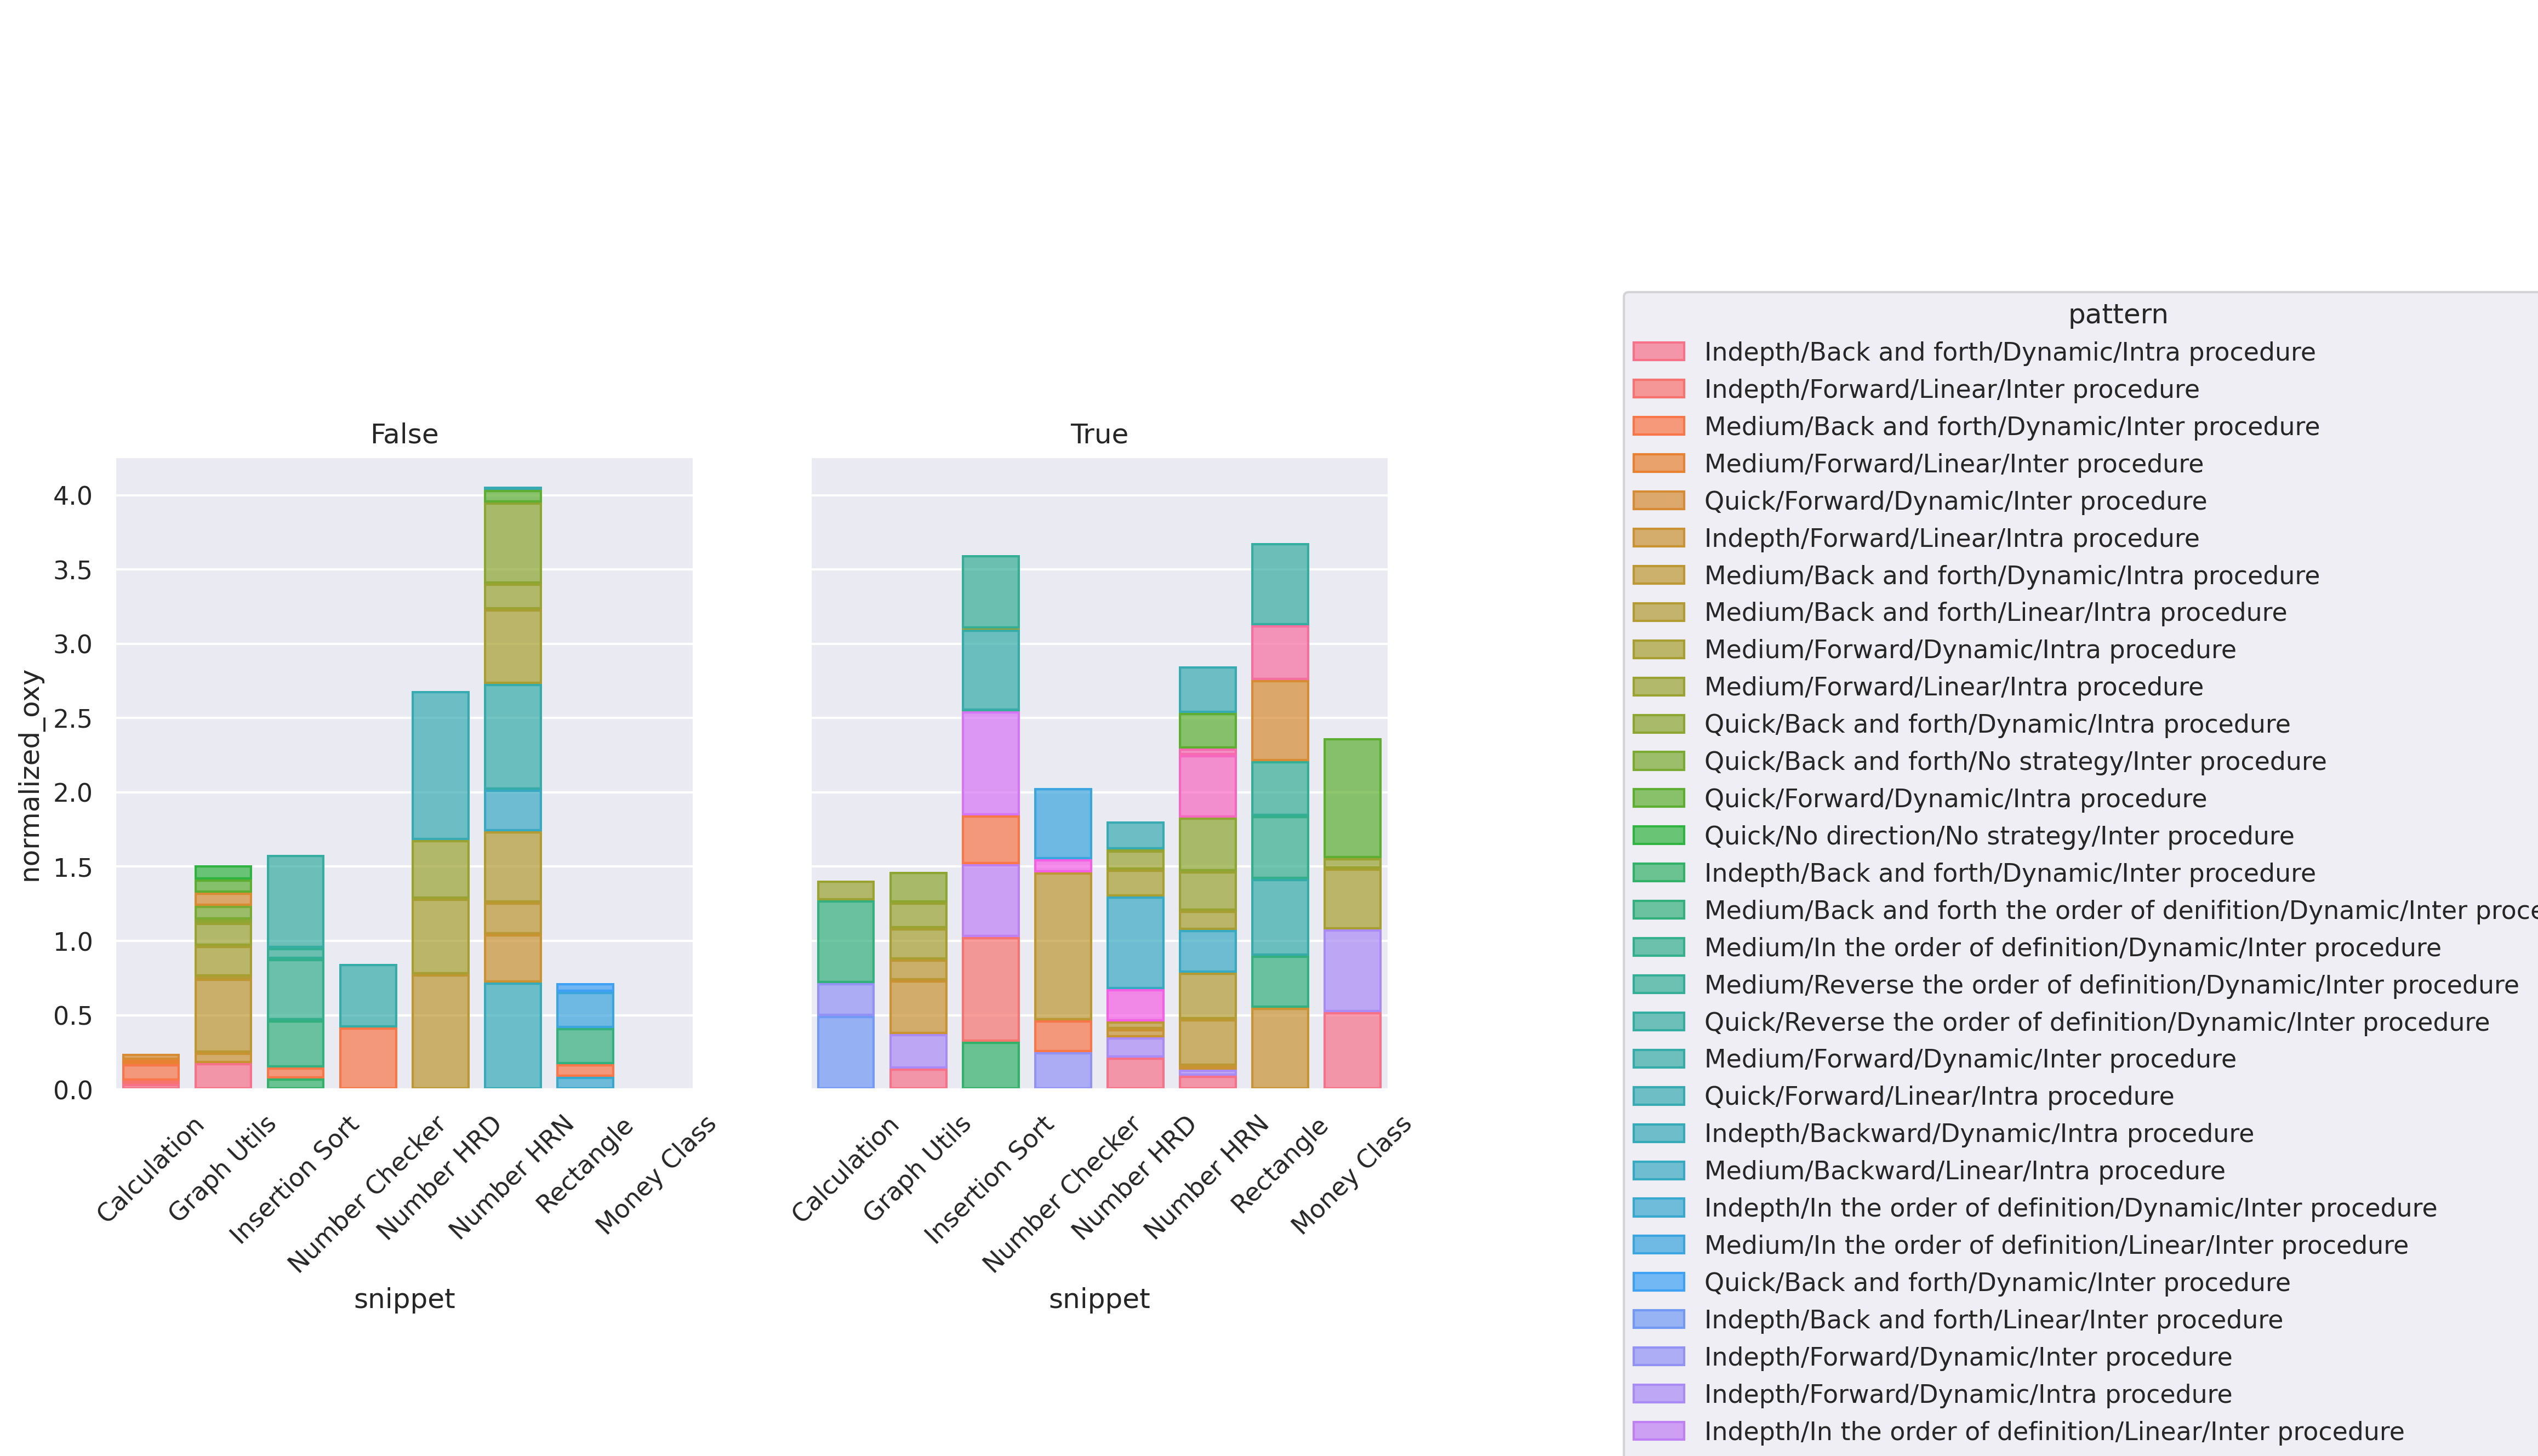

In [27]:
import seaborn.objects as so
from matplotlib.figure import Figure

d = combined_fnirs.groupby(['correctness', 'snippet', 'pattern'])['normalized_oxy'].mean().reset_index()


fig = Figure(figsize=(10, 5), dpi=300)
p = so.Plot(
    d.assign(pattern=d['pattern'].str.join('/')),
    x='snippet',
    y='normalized_oxy',
    color='pattern'
).facet(col='correctness', ).add(so.Bar(), so.Stack()).on(fig).plot()
# for ax in fig.axes:
ax = fig.axes[-1]
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax = fig.axes[-2]
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
display(fig)

In [28]:
d.pivot_table(columns='correctness', index =['snippet', 'pattern'], values='normalized_oxy').to_clipboard()

In [29]:
combined_fnirs.groupby(["snippet", "pattern", "correctness"]).apply(
    lambda df: len(df[["pid", "tid"]].drop_duplicates())
).reset_index(name='counts').sort_values(by='snippet')


,snippet,pattern,correctness,counts
0,Calculation,"(Indepth, Back and forth, Dynamic, Intra proce...",False,1
10,Calculation,"(Quick, Forward, Dynamic, Inter procedure)",True,1
8,Calculation,"(Medium, In the order of definition, Linear, I...",True,1
7,Calculation,"(Medium, Forward, Linear, Intra procedure)",True,1
6,Calculation,"(Medium, Forward, Linear, Inter procedure)",False,1
...,...,...,...,...
99,Rectangle,"(Medium, Back and forth, Dynamic, Inter proced...",False,1
98,Rectangle,"(Indepth, In the order of definition, Dynamic,...",False,1
108,Rectangle,"(Quick, In the order of definition, Dynamic, I...",True,1
102,Rectangle,"(Medium, Forward, Dynamic, Inter procedure)",True,3


In [30]:
load_manual_annotation_data()

snippet  correctness investment selection_strategy  \
pid tid                                                          
p52 t1   Number HRD         True     Medium        No strategy   
    t1   Number HRD         True     Medium            Dynamic   
    t1   Number HRD         True     Medium             Linear   
    t1   Number HRD         True     Medium            Dynamic   
    t1   Number HRD         True     Medium             Linear   
...             ...          ...        ...                ...   
p48 t1   Number HRD         True    Indepth            Dynamic   
p74 t3   Number HRD         True     Medium             Linear   
    t3   Number HRD         True      Quick            Dynamic   
    t3   Number HRD         True     Medium             Linear   
    t3   Number HRD         True     Medium            Dynamic   

              direction code_interaction  start_time  end_time  duration  
pid tid                                                                   
p52 t1         Backward  Intra procedure           0         7         7  
    t1     No direction  Intra procedure           7        35        28  
    t1          Forward  Intra procedure          35        55        20  
    t1          Forward  Intra procedure          55        95        40  
    t1   Back and forth  Intra procedure         102       116        14  
...                 ...              ...         ...       ...       ...  
p48 t1   Back and forth  Intra procedure         258       291        33  
p74 t3          Forward  Intra procedure           0        23        23  
    t3   Back and forth  Intra procedure          48       147        99  
    t3          Forward  Intra procedure         147       248       101  
    t3   Back and forth  Intra procedure         248       500       252  

[586 rows x 9 columns]

In [50]:
subset = fnirs.join(correctness).dropna().query('snippet == "money_class"')

In [53]:
fixations = pd.read_parquet('../data/processed/fixations-fixed.parq')
res = []


for (pid, tid) in subset.index.unique():
    subset_fixations = fixations.loc[(pid, tid)]
    subset_fnirs = subset.loc[(pid, tid)]

    r = synchronizeFnirAndGazeData(subset_fixations, subset_fnirs,  gaze_time_col='start_time')
    r['pid'] = pid
    r['tid'] = tid
    r.set_index(['pid', 'tid'], inplace=True)
    res.append(r)

synced = pd.concat(res)

ValueError: No objects to concatenate

In [54]:
import functools
from math import floor

import numpy as np
import pandas as pd
from tqdm.auto import tqdm


def compute_mean(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(df.mean().to_dict(), index=[df.index.values[-1]])


def synchronizeFnirAndGazeData(
    gaze_data,
    fnir_data,
    aggregation_time_window=60.0,
    fnir_time_col="Time",
    gaze_time_col="system_time",
    gaze_duration_col="duration",
    drop_unsynced_gaze=False,
):
    gaze_data = gaze_data.sort_values(by=gaze_time_col).to_dict("records")
    fnir_data = fnir_data.sort_values(by=fnir_time_col).to_dict("records")

    gaze_data_idx = 0
    fnir_data_idx = 0

    results = []
    with tqdm(total=len(gaze_data)) as bar:
        bar.set_description("processing gazes")
        while gaze_data_idx < len(gaze_data) and fnir_data_idx < len(
                fnir_data):
            # for current gaze idx, find all fnir points that correspond
            gaze_point = gaze_data[gaze_data_idx]
            gaze_point_time = gaze_point[gaze_time_col]
            gaze_duration = gaze_point[gaze_duration_col]
            bounds = [
                gaze_point_time - aggregation_time_window,
                gaze_point_time + gaze_duration + aggregation_time_window,
            ]
            fnir_points_for_current_gaze = []

            while fnir_data_idx < len(fnir_data):
                fnir_point = fnir_data[fnir_data_idx]
                fnir_time = fnir_point[fnir_time_col]

                if fnir_time >= bounds[0] and fnir_time <= bounds[1]:
                    fnir_points_for_current_gaze.append(fnir_point)
                elif fnir_time > bounds[1]:
                    break
                fnir_data_idx += 1

            if fnir_points_for_current_gaze:

                fnir_data_for_gaze = (compute_mean(
                    pd.DataFrame(fnir_points_for_current_gaze)).drop(
                        "Time", axis=1)).to_dict("records")[0]

                sync_point = {**gaze_point, **fnir_data_for_gaze}

                results.append(sync_point)
            elif not drop_unsynced_gaze:
                sync_point = {**gaze_point}
                results.append(sync_point)

            bar.update()
            gaze_data_idx += 1

    results = pd.DataFrame(results)

    return results


In [55]:
synced = synced.dropna(subset='oxy_optode_avg')
synced['normalized_oxy'] = (synced['oxy_optode_avg'] - synced['oxy_optode_avg'].min()) / np.ptp(synced['oxy_optode_avg'])


by_line = synced.groupby('source_file_line')['normalized_oxy'].mean().reset_index().sort_values(by='normalized_oxy')

NameError: name 'synced' is not defined

In [58]:
by_line.assign(source_file_line=by_line['source_file_line'] + 1)

NameError: name 'by_line' is not defined

In [57]:
# fixations
fixations.join(correctness).query('snippet == "money_class"').groupby(
    "source_file_line"
)["duration"].mean().reset_index().sort_values(by="duration")


,source_file_line,duration


In [56]:
fixations.join(correctness).query('snippet == "money_class" & source_file_line == 14')[["duration"]].sort_values(
    by="duration", ascending=False
)


# sns.displot()
subset.loc[('p101', 't2')]

KeyError: 'p101'